In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Load dataset

In [136]:
from fingerprint_dataset import FingerprintDataset

plus = {
    'real': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/PLUS/real/', pattern='.+_(PALMAR|DORSAL)_(?P<id>[0-9]+)_[0-9]+_(?P<finger>[0-9]+)_(?P<image_id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/PLUS/spoof/', pattern='.+_(PALMAR|DORSAL)_(?P<id>[0-9]+)_[0-9]+_(?P<finger>[0-9]+)_(?P<image_id>[0-9]+).png')
}
plus_vae = {
    'real': FingerprintDataset(directory='../data/VAE-diff/PLUS_matched/real/', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/VAE-diff/PLUS_matched/spoof/', pattern='sample_(?P<id>[0-9]+).png')
}
plus_ae = {
    'real': FingerprintDataset(directory='../data/AE_Res-diff/PLUS_matched/real/', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/AE_Res-diff/PLUS_matched/spoof/', pattern='sample_(?P<id>[0-9]+).png')
}

idiap = {
    'real': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/IDIAP/full/dev/real/', pattern='(?P<id>[0-9]+)_(?P<finger>L|R)_(?P<image_id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/IDIAP/full/dev/spoof/', pattern='(?P<id>[0-9]+)_(?P<finger>L|R)_(?P<image_id>[0-9]+).png')
}
idiap_vae = {
    'real': FingerprintDataset(directory='../data/VAE-diff/IDIAP/real/', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/VAE-diff/IDIAP/spoof/', pattern='sample_(?P<id>[0-9]+).png')
}
idiap_ae = {
    'real': FingerprintDataset(directory='../data/AE_Res-diff/IDIAP/real/', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/AE_Res-diff/IDIAP/spoof/', pattern='sample_(?P<id>[0-9]+).png')
}

scut = {
    'real': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/SCUT/roi/dev/real', pattern='(?P<id>[0-9]+)_(?P<finger>[0-9]+)_[0-9]+_[0-9]+_[0-9]+.bmp'),
    'spoof': FingerprintDataset(directory='../data/Data_FV_Spoofing_WS2025_26/SCUT/roi/dev/spoof', pattern='(?P<id>[0-9]+)_(?P<finger>[0-9]+)_[0-9]+_[0-9]+_[0-9]+.bmp')
}
scut_vae = {
    'real': FingerprintDataset(directory='../data/VAE-diff/SCUT/roi/dev/real', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/VAE-diff/SCUT/roi/dev/spoof', pattern='sample_(?P<id>[0-9]+).png')
}
scut_ae = {
    'real': FingerprintDataset(directory='../data/AE_Res-diff/SCUT/roi/dev/real', pattern='sample_(?P<id>[0-9]+).png'),
    'spoof': FingerprintDataset(directory='../data/AE_Res-diff/SCUT/roi/dev/spoof', pattern='sample_(?P<id>[0-9]+).png')
}

In [137]:
dataset = idiap
dataset_title = 'IDIAP'
dataset_vae = idiap_vae
dataset_ae = idiap_ae

In [138]:
# Keep only real images that have a spoof counterpart
dataset['real'].filter_by_df(dataset['spoof'].get_df(), on_columns=['id', 'finger'])

# Add labels
dataset['real'].get_df_mut()['label'] = 0
dataset['spoof'].get_df_mut()['label'] = 1

# Concatinate real and spoof dataframes
df = pd.concat([dataset['real'].get_df_mut(), dataset['spoof'].get_df_mut()]).reset_index().drop(columns=['index'])

dataset_vae['real'].filter_by_df(dataset_vae['spoof'].get_df(), on_columns=['id'])
dataset_vae['real'].get_df_mut()['label'] = 0
dataset_vae['spoof'].get_df_mut()['label'] = 1
df_vae = pd.concat([dataset_vae['real'].get_df_mut(), dataset_vae['spoof'].get_df_mut()]).reset_index().drop(columns=['index'])
df_vae

dataset_ae['real'].filter_by_df(dataset_ae['spoof'].get_df(), on_columns=['id'])
dataset_ae['real'].get_df_mut()['label'] = 0
dataset_ae['spoof'].get_df_mut()['label'] = 1
df_ae = pd.concat([dataset_ae['real'].get_df_mut(), dataset_ae['spoof'].get_df_mut()]).reset_index().drop(columns=['index'])
df_ae

,id,file_path,label
0,0,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0
1,1,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0
2,10,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0
3,100,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0
4,1000,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0
...,...,...,...
4091,995,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1
4092,996,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1
4093,997,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1
4094,998,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1


In [139]:
from sklearn.model_selection import GroupKFold

def add_stratified_folds(df, group_col='id', shuffle=True, random_state=42, n_splits=5):
    """
    Adds a 'fold' column to the dataframe ensuring that all rows 
    belonging to the same user (group) stay within the same fold.
    """
    # Initialize the GroupKFold object
    gkf = GroupKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    # Create a placeholder column
    df['fold'] = -1
    
    groups= df[group_col]
    # Since we only care about the groups, we pass dummy values for X and y.
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(df, groups=groups)):
        # Assign the fold index to the rows designated as the 'test' set for this split
        df.loc[df.index[test_idx], 'fold'] = fold_idx
        
    return df

add_stratified_folds(df)
add_stratified_folds(df_vae)
add_stratified_folds(df_ae)

,id,file_path,label,fold
0,0,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0,2
1,1,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0,4
2,10,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0,1
3,100,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0,2
4,1000,../data/AE_Res-diff/IDIAP/real/samples\sample_...,0,3
...,...,...,...,...
4091,995,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1,2
4092,996,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1,4
4093,997,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1,3
4094,998,../data/AE_Res-diff/IDIAP/spoof/samples\sample...,1,1


# Step 2: Feature extraction

In [140]:
from PIL import Image
from skimage.feature import local_binary_pattern

def extract_lbp_features(file_path, settings):
    """
    Converts an image file to a 256-bin normalized LBP histogram.
    """
    img = Image.open(file_path).convert('L')
    img_array = np.array(img)
    
    lbp = local_binary_pattern(img_array, settings['P'], settings['R'], method=settings['method'])
    
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

# Step 4: Crossvalidation

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from itertools import combinations
import random

def compute_error_rates(true_labels, pred_labels):
    """Compute APCER, BPCER, ACER."""
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Define mapping
    labels = [0, 1]  # Ensure consistent order

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    #print(cm)
    TN, FP, FN, TP = cm.ravel()  # Unpack the matrix

    apcer = FN/(FN+TP)
    bpcer = FP/(FP+TN)
    acer = 0.5 * (apcer + bpcer)
    return acer, apcer, bpcer

def get_fold_data(df, train_folds: list = [], val_folds: list = [], df_syn = pd.DataFrame(), amount_syn = 0):
    amount_auth = max(0, len(train_folds) - amount_syn)
    auth_folds = train_folds[:amount_auth]
    syn_folds = train_folds[amount_auth:]
    
    train_df_auth = df[df['fold'].isin(auth_folds)]
    if not df_syn.empty:
        train_df_syn = df_syn[df_syn['fold'].isin(syn_folds)]
        train_df = pd.concat([train_df_auth, train_df_syn])
    else:
        train_df = train_df_auth
    
    val_df = df[df['fold'].isin(val_folds)]

    X_train = np.stack(train_df['features'].values)
    X_val = np.stack(val_df['features'].values)

    y_train = train_df['label']
    y_val = val_df['label']

    return X_train, y_train, X_val, y_val

def crossvalidation(df, k=5, df_syn = pd.DataFrame()):
    folds = {0, 1, 2, 3, 4}
    errors = []
    
    for i in range(0, 5):
        train_folds_list = list({0, 1, 2, 3, 4} - {i})
        random.shuffle(train_folds_list)

        # train = 4/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.append(compute_error_rates(y_val, predictions))

        # train = 2/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.append(compute_error_rates(y_val, predictions))

        # train = 1/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:1], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_val, y_val)
        predictions = knn.predict(X_train)
        errors.append(compute_error_rates(y_train, predictions))

        if not df_syn.empty:
            # train = 1+1/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i], df_syn = df_syn, amount_syn = 1)
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_val, y_val)
            predictions = knn.predict(X_train)
            errors.append(compute_error_rates(y_train, predictions))

            # train = 1+3/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i], df_syn = df_syn, amount_syn = 3)
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_val, y_val)
            predictions = knn.predict(X_train)
            errors.append(compute_error_rates(y_train, predictions))

    
    return errors

## Run experiments

In [142]:
metrics = ['ACER', 'APCER', 'BPCER']
ks = [3, 5, 7, 9]
lbp_settings = [
    { 'P': 8, 'R': 1, 'method': 'default', 'title': 'Default' },
    { 'P': 8, 'R': 1, 'method': 'ror', 'title': 'Rotation Invariant' },
    { 'P': 8, 'R': 1, 'method': 'uniform', 'title': 'Uniform' },
    { 'P': 8, 'R': 1, 'method': 'nri_uniform', 'title': 'Uniform Grayscale Invariant' },
    { 'P': 8, 'R': 1, 'method': 'var', 'title': 'Contrast Variance' },
]

In [143]:
import time

feature_dfs = []
for idx, setting in enumerate(lbp_settings):
    print(f'({idx+1}/{len(lbp_settings)}) Extracting features for LBP method [authentic] {setting['title']} ... ', end='')
    start_time = time.time()
    fdf = df.copy()
    fdf['features'] = fdf['file_path'].apply(lambda x: extract_lbp_features(x, setting))
    elapsed_time = time.time() - start_time
    print(f'done! Took {elapsed_time:.4f}s')
    feature_dfs.append(fdf)
    fdf.to_pickle(f'{dataset_title}_lbp-{setting['method']}.pkl')

(1/5) Extracting features for LBP method [authentic] Default ... done! Took 5.8218s
(2/5) Extracting features for LBP method [authentic] Rotation Invariant ... done! Took 4.9625s
(3/5) Extracting features for LBP method [authentic] Uniform ... done! Took 6.1536s
(4/5) Extracting features for LBP method [authentic] Uniform Grayscale Invariant ... done! Took 5.8803s
(5/5) Extracting features for LBP method [authentic] Contrast Variance ... done! Took 4.6237s


In [144]:
feature_dfs_vae = []
for idx, setting in enumerate(lbp_settings):
    print(f'({idx+1}/{len(lbp_settings)}) Extracting features for LBP method [VAE] {setting['title']} ... ', end='')
    start_time = time.time()
    fdf = df_vae.copy()
    fdf['features'] = fdf['file_path'].apply(lambda x: extract_lbp_features(x, setting))
    elapsed_time = time.time() - start_time
    print(f'done! Took {elapsed_time:.4f}s')
    feature_dfs_vae.append(fdf)
    fdf.to_pickle(f'{dataset_title}-VAE_lbp-{setting['method']}.pkl')

(1/5) Extracting features for LBP method [VAE] Default ... done! Took 88.0377s
(2/5) Extracting features for LBP method [VAE] Rotation Invariant ... done! Took 89.2951s
(3/5) Extracting features for LBP method [VAE] Uniform ... done! Took 93.6338s
(4/5) Extracting features for LBP method [VAE] Uniform Grayscale Invariant ... done! Took 99.4440s
(5/5) Extracting features for LBP method [VAE] Contrast Variance ... done! Took 83.7705s


In [145]:
feature_dfs_ae = []
for idx, setting in enumerate(lbp_settings):
    print(f'({idx+1}/{len(lbp_settings)}) Extracting features for LBP method [VAE] {setting['title']} ... ', end='')
    start_time = time.time()
    fdf = df_ae.copy()
    fdf['features'] = fdf['file_path'].apply(lambda x: extract_lbp_features(x, setting))
    elapsed_time = time.time() - start_time
    print(f'done! Took {elapsed_time:.4f}s')
    feature_dfs_ae.append(fdf)
    fdf.to_pickle(f'{dataset_title}-AE_lbp-{setting['method']}.pkl')

(1/5) Extracting features for LBP method [VAE] Default ... done! Took 117.2854s
(2/5) Extracting features for LBP method [VAE] Rotation Invariant ... done! Took 139.5504s
(3/5) Extracting features for LBP method [VAE] Uniform ... done! Took 91.1541s
(4/5) Extracting features for LBP method [VAE] Uniform Grayscale Invariant ... done! Took 99.1293s
(5/5) Extracting features for LBP method [VAE] Contrast Variance ... done! Took 84.3292s


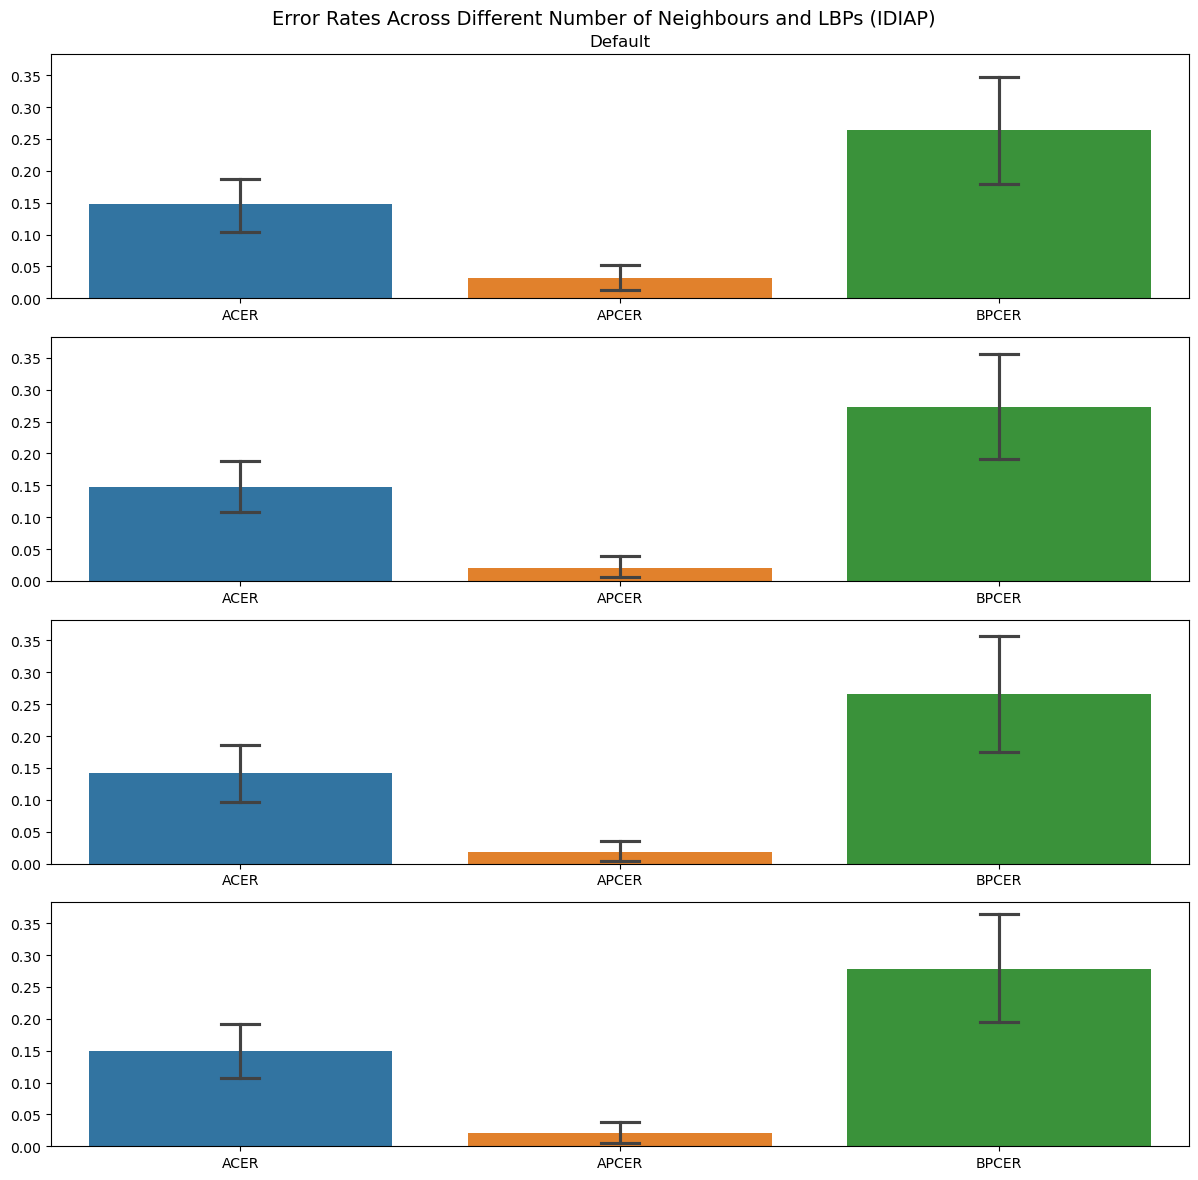

In [112]:
fig, axes = plt.subplots(nrows=len(ks), ncols=len(feature_dfs), figsize=(12, 12), sharey=True)
fig.suptitle('Error Rates Across Different Number of Neighbours and LBPs (IDIAP)', fontsize=14)

for r, k in enumerate(ks):
    ax = axes[r]
    if r == 0:
        ax.set_title(lbp_settings[c]['title'])
    errors_df = pd.DataFrame(crossvalidation(feature_dfs[0], k=k, df_syn=feature_dfs_vae[0]), columns=metrics)
    sns.barplot(data=errors_df, capsize=.1, ax=ax)

plt.tight_layout()
plt.show()

In [25]:
from datetime import datetime

# Get current time
now = datetime.now()

# Format: results_DD-MM-YYYY_HH-MM-SS
filename = now.strftime("results_%d-%m-%Y_%H-%M-%S.pdf")
fig.savefig(filename, format="pdf")

## Sanity Check

In [52]:
def generate_random_test_data(num_samples=100, num_ids=20):
    # 1. Generate non-unique IDs
    ids = np.random.randint(0, num_ids, size=num_samples)

    # 2. Generate Feature Vectors (10 floats per row)
    features = np.random.uniform(low=-1.0, high=1.0, size=(num_samples, 10))

    # 3. Generate Random Labels {0, 1} 
    # This ensures an expected error rate of 50% (random chance)
    labels = np.random.choice([0, 1], size=num_samples)

    # 4. Inject ID information into features to test separation of users in different folds
    features[:, 0] = ids

    # 5. Assemble the DataFrame
    df = pd.DataFrame({
        'id': ids,
        'features': [arr for arr in features],
        'label': labels
    })

    return df.sort_values('id').reset_index(drop=True)

random_df = generate_random_test_data()
add_stratified_folds(random_df, random_state=1337)

random_df.groupby('id')['fold'].nunique()

id
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: fold, dtype: int64

In [53]:
errors = crossvalidation(random_df)
for acer, apcer, bpcer in errors:
    print("================================================")
    print(f"ACER \t= {acer}")
    print(f"APCER \t= {apcer}")
    print(f"BPCER \t= {bpcer}")

ACER 	= 0.5625
APCER 	= 0.125
BPCER 	= 1.0
ACER 	= 0.4444444444444444
APCER 	= 0.2222222222222222
BPCER 	= 0.6666666666666666
ACER 	= 0.5384615384615384
APCER 	= 0.07692307692307693
BPCER 	= 1.0
ACER 	= 0.4444444444444444
APCER 	= 0.5555555555555556
BPCER 	= 0.3333333333333333
ACER 	= 0.3966346153846154
APCER 	= 0.5625
BPCER 	= 0.23076923076923078


In [34]:
all_fold_pairs = list(combinations([0, 1, 2, 3, 4], 3))
selected_pairs = random.sample(all_fold_pairs, 10)
print(selected_pairs)
df[df['fold'].isin(selected_pairs[0])].groupby('fold')['id'].nunique()

[(2, 3, 4), (0, 2, 3), (0, 1, 2), (0, 2, 4), (0, 1, 4), (1, 2, 4), (0, 3, 4), (0, 1, 3), (1, 3, 4), (1, 2, 3)]


fold
2    4
3    4
4    4
Name: id, dtype: int64

In [35]:
list((1, 2, 3))

[1, 2, 3]